# Pivoted Document Length Normalization

## Background

In many cases, normalizing the tfidf weights for each term favors weight of terms of the documents with shorter length. The _pivoted document length normalization_ scheme counters the effect of this bias for short documents by making tfidf independent of the document length.

This is achieved by *tilting* the normalization curve along the pivot point defined by user with some slope.
Roughly following the equation:

`pivoted_norm = (1 - slope) * pivot + slope * old_norm`

This scheme is proposed in the paper [Pivoted Document Length Normalization](http://singhal.info/pivoted-dln.pdf) by Singhal, Buckley and Mitra.

Overall this approach can in many cases help increase the accuracy of the model where the document lengths are hugely varying in the entire corpus.

## Introduction

This guide demonstrates how to perform pivoted document length normalization.
We will train a logistic regression to distinguish between text from two different newsgroups.
Our results will show that using pivoted document length normalization yields a better model (higher classification accuracy).

In [1]:
#
# Download our dataset
#
import gensim.downloader as api
nws = api.load("20-newsgroups")

#
# Pick texts from relevant newsgroups, split into training and test set.
#
cat1, cat2 = ('sci.electronics', 'sci.space')

#
# X_* contain the actual texts as strings.
# Y_* contain labels, 0 for cat1 (sci.electronics) and 1 for cat2 (sci.space)
#
X_train = []
X_test = []
y_train = []
y_test = []

for i in nws:
    if i["set"] == "train" and i["topic"] == cat1:
        X_train.append(i["data"])
        y_train.append(0)
    elif i["set"] == "train" and i["topic"] == cat2:
        X_train.append(i["data"])
        y_train.append(1)
    elif i["set"] == "test" and i["topic"] == cat1:
        X_test.append(i["data"])
        y_test.append(0)
    elif i["set"] == "test" and i["topic"] == cat2:
        X_test.append(i["data"])
        y_test.append(1)

In [2]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora import Dictionary

id2word = Dictionary([preprocess_string(doc) for doc in X_train])
train_corpus = [id2word.doc2bow(preprocess_string(doc)) for doc in X_train]
test_corpus = [id2word.doc2bow(preprocess_string(doc)) for doc in X_test]

In [3]:
print(len(X_train), len(X_test))

1184 787


In [4]:
# We perform our analysis on top k documents which is almost top 10% most scored documents
k = len(X_test) // 10

In [5]:
from gensim.sklearn_api.tfidf import TfIdfTransformer
from sklearn.linear_model import LogisticRegression
from gensim.matutils import corpus2csc

# This function returns the model accuracy and indivitual document prob values using
# gensim's TfIdfTransformer and sklearn's LogisticRegression
def get_tfidf_scores(kwargs):
    tfidf_transformer = TfIdfTransformer(**kwargs).fit(train_corpus)

    X_train_tfidf = corpus2csc(tfidf_transformer.transform(train_corpus), num_terms=len(id2word)).T
    X_test_tfidf = corpus2csc(tfidf_transformer.transform(test_corpus), num_terms=len(id2word)).T

    clf = LogisticRegression().fit(X_train_tfidf, y_train)

    model_accuracy = clf.score(X_test_tfidf, y_test)
    doc_scores = clf.decision_function(X_test_tfidf)

    return model_accuracy, doc_scores

### Get TFIDF scores for corpus without pivoted document length normalisation

In [6]:
params = {}
model_accuracy, doc_scores = get_tfidf_scores(params)
print(model_accuracy)

0.9682337992376112


/home/misha/envs/gensim/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
import numpy as np

# Sort the document scores by their scores and return a sorted list
# of document score and corresponding document lengths.
def sort_length_by_score(doc_scores, X_test):
    doc_scores = sorted(enumerate(doc_scores), key=lambda x: x[1])
    doc_leng = np.empty(len(doc_scores))

    ds = np.empty(len(doc_scores))

    for i, _ in enumerate(doc_scores):
        doc_leng[i] = len(X_test[_[0]])
        ds[i] = _[1]

    return ds, doc_leng


print(
   "Normal cosine normalisation favors short documents as our top {} "
   "docs have a smaller mean doc length of {:.3f} compared to the corpus mean doc length of {:.3f}"
   .format(
       k, sort_length_by_score(doc_scores, X_test)[1][:k].mean(), 
       sort_length_by_score(doc_scores, X_test)[1].mean()
   )
)

Normal cosine normalisation favors short documents as our top 78 docs have a smaller mean doc length of 1668.179 compared to the corpus mean doc length of 1577.799


### Get TFIDF scores for corpus with pivoted document length normalisation testing on various values of alpha.

In [8]:
best_model_accuracy = 0
optimum_slope = 0
for slope in np.arange(0, 1.1, 0.1):
    params = {"pivot": 10, "slope": slope}

    model_accuracy, doc_scores = get_tfidf_scores(params)

    if model_accuracy > best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope = slope

    print("Score for slope {} is {}".format(slope, model_accuracy))

print("We get best score of {} at slope {}".format(best_model_accuracy, optimum_slope))

Score for slope 0.0 is 0.9720457433290979
Score for slope 0.1 is 0.9758576874205845
Score for slope 0.2 is 0.97712833545108
Score for slope 0.30000000000000004 is 0.9783989834815756
Score for slope 0.4 is 0.97712833545108
Score for slope 0.5 is 0.9758576874205845
Score for slope 0.6000000000000001 is 0.9733163913595934
Score for slope 0.7000000000000001 is 0.9733163913595934
Score for slope 0.8 is 0.9733163913595934
Score for slope 0.9 is 0.9733163913595934
Score for slope 1.0 is 0.9682337992376112
We get best score of 0.9783989834815756 at slope 0.30000000000000004


In [9]:
params = {"pivot": 10, "slope": optimum_slope}
model_accuracy, doc_scores = get_tfidf_scores(params)
print(model_accuracy)

0.9783989834815756


In [10]:
print(
   "With pivoted normalisation top {} docs have mean length of {:.3f} "
   "which is much closer to the corpus mean doc length of {:.3f}"
   .format(
       k, sort_length_by_score(doc_scores, X_test)[1][:k].mean(), 
       sort_length_by_score(doc_scores, X_test)[1].mean()
   )
)

With pivoted normalisation top 78 docs have mean length of 2077.346 which is much closer to the corpus mean doc length of 1577.799


## Visualizing the pivoted normalization

Since cosine normalization favors retrieval of short documents from the plot we can see that when slope was 1 (when pivoted normalisation was not applied) short documents with length of around 500 had very good score hence the bias for short documents can be seen. As we varied the value of slope from 1 to 0 we introdcued a new bias for long documents to counter the bias caused by cosine normalisation. Therefore at a certain point we got an optimum value of slope which is 0.5 where the overall accuracy of the model is increased.


/home/misha/envs/gensim/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


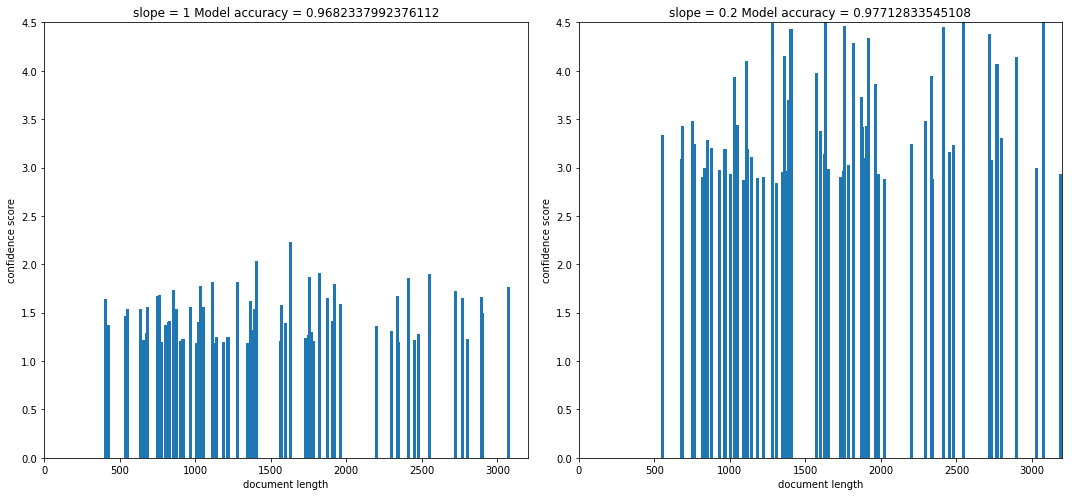

In [11]:
%matplotlib inline
import matplotlib.pyplot as py

best_model_accuracy = 0
optimum_slope = 0

w = 2
h = 2
f, axarr = py.subplots(h, w, figsize=(15, 7))

it = 0
for slope in [1, 0.2]:
    params = {"pivot": 10, "slope": slope}

    model_accuracy, doc_scores = get_tfidf_scores(params)

    if model_accuracy > best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope = slope

    doc_scores, doc_leng = sort_length_by_score(doc_scores, X_test)

    y = abs(doc_scores[:k, np.newaxis])
    x = doc_leng[:k, np.newaxis]

    py.subplot(1, 2, it+1).bar(x, y, width=20, linewidth=0)
    py.title("slope = " + str(slope) + " Model accuracy = " + str(model_accuracy))
    py.ylim([0, 4.5])
    py.xlim([0, 3200])
    py.xlabel("document length")
    py.ylabel("confidence score")
    
    it += 1

py.tight_layout()
py.show()

The above histogram plot helps us visualize the effect of `slope`. For top k documents we have document length on the x axis and their respective scores of belonging to a specific class on y axis.  
As we decrease the slope the density of bins is shifted from low document length (around ~250-500) to over ~500 document length. This suggests that the positive biasness which was seen at `slope=1` (or when regular tfidf was used) for short documents is now reduced. We get the optimum slope or the max model accuracy when slope is 0.2.

# Conclusion

Using pivoted document normalization improved the classification accuracy significantly:

- Before (slope=1, identical to default cosine normalization): 0.9682
- After (slope=0.2): 0.9771